## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import catboost as cb
from catboost import cv
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, recall_score
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import numpy as np

%matplotlib inline

In [2]:
train_df = pd.read_csv("train_dataset_train.csv")
train_df.head(3)

,id,type
0,ОРГ1-02050,2
1,ОРГ1-02783,2
2,ОРГ2-06173,0


In [3]:
# всего сотрудников
train_df.id.nunique()

550

## Посмотрим на признаки

#### Образование

In [4]:
edu = pd.read_csv('Education.csv')
edu = edu.drop_duplicates()
edu.head(3)

,Табельный номер руководителя,id,Вид образования,Специальность
0,NaN,ОРГ1-00131,Высшее образование - бакалавриат,Юриспруденция
1,NaN,ОРГ1-03220,Среднее профессиональное образование,Финансы
2,NaN,ОРГ1-03008,Высшее образование,Юриспруденция


In [5]:
edu.rename(columns={'Вид образования': 'Вид_образования'}, inplace=True)
edu.nunique()

Табельный номер руководителя     152
id                              4788
Вид_образования                   16
Специальность                   1082
dtype: int64

In [6]:
edu['Вид_образования'].value_counts(dropna=False)

Высшее образование                                1437
Среднее профессиональное образование              1009
Среднее общее образование                          620
Начальное профессиональное образование             572
Профессиональное обучение                          497
Высшее образование - бакалавриат                   365
Высшее образование - специалитет, магистратура     327
Повышение квалификации                             297
Среднее (полное) общее образование                 111
NaN                                                 98
Основное общее образование                          66
Переподготовка                                      52
Дополнительное профессиональное образование         23
Неполное высшее образование                         21
Начальное общее образование                          6
Аспирантура                                          6
Послевузовское образование                           2
Name: Вид_образования, dtype: int64

In [7]:
v = edu.groupby('id') \
    .agg({'Табельный номер руководителя': ['count', pd.Series.nunique]})
(v['Табельный номер руководителя']['nunique'] > 1).sum()

0

In [8]:
comp = ('Переподготовка', 'Повышение квалификации', 'Послевузовское образование')
edu_comp = edu.query("Вид_образования in @comp")

In [9]:
edu_list = []
for l in edu['Специальность'].apply(lambda x: word_tokenize(str(x), language='russian')).values:
    edu_list.extend([word.strip('"./,()').lower() for word in l])
words = pd.DataFrame(data=edu_list, columns=['words']).value_counts().to_frame().reset_index()
words_to_stop = words.query("words.str.len() <= 3")
words_to_stop

,words,0
0,и,2157
1,,833
2,nan,663
6,по,358
8,на,288
...,...,...
1459,си,1
1476,рк,1
1491,ж/д,1
1512,ии,1


In [10]:
# определим служебные слова и сокращения, которые не добавляют смысловой нагрузки
stops = stopwords.words("russian")
stops.extend(list(set(words_to_stop.words.values) - set(['ж/д', 'c/x', 'эвм', 'c-x'])))

In [11]:
# Функция, фильтрующая стоп-слова и оставляющая только основу слов
def stem_filter_words(row):
    snowball = SnowballStemmer(language="russian")
    filtered_stemmed_row = []
    for token in row:
        if token.lower() not in stops and token.isalpha():
            filtered_stemmed_row.append(snowball.stem(token))
    return filtered_stemmed_row

edu['Специальность'] = edu['Специальность'].apply(lambda x: word_tokenize(str(x), language='russian')) \
                                            .apply(stem_filter_words)

In [12]:
edu['Вид_образования'] = edu['Вид_образования'].apply(lambda x: word_tokenize(str(x), language='russian')) \
                                            .apply(stem_filter_words)
edu.head()

,Табельный номер руководителя,id,Вид_образования,Специальность
0,NaN,ОРГ1-00131,"[высш, образован, бакалавриат]",[юриспруденц]
1,NaN,ОРГ1-03220,"[средн, профессиональн, образован]",[финанс]
2,NaN,ОРГ1-03008,"[высш, образован]",[юриспруденц]
3,NaN,ОРГ1-00922,"[высш, образован, бакалавриат]","[бакалавр, техническ, наук]"
4,NaN,ОРГ1-00922,"[высш, образован]","[машин, аппарат, химическ, производств, предпр..."


In [13]:
edu = edu.groupby(['id'], as_index=False).agg({'Вид_образования': 'sum', 'Специальность': 'sum', 'Табельный номер руководителя': 'count'})

In [14]:
edu['Вид_образования'] = edu['Вид_образования'].apply(lambda x: ' '.join(list(set(x))))
edu['Специальность'] = edu['Специальность'].apply(lambda x: ' '.join(list(set(x))))

In [15]:
edu['Повышение_квалификации'] = edu.id.apply(lambda x: 1 if x in edu_comp.id.values else 0)

In [16]:
edu.rename(columns={'Табельный номер руководителя': 'Кол-во курсов'}, inplace=True)
edu.head()

,id,Вид_образования,Специальность,Кол-во курсов,Повышение_квалификации
0,ОРГ1-00001,образован повышен высш квалификац,организац технолог здан химическ проектн деяте...,0,1
1,ОРГ1-00004,образован повышен высш квалификац,применен вопрос систем стребован стандарт мене...,4,1
2,ОРГ1-00005,образован повышен высш квалификац,электроэнергетическ здан деятельн сооружен мен...,6,1
3,ОРГ1-00010,образован высш,экономик организац промышлен машиностроительн,0,0
4,ОРГ1-00013,образован высш,социальн систем стребован стандарт менеджмент ...,3,0


In [17]:
df = edu

#### Звонки

In [18]:
calls = pd.read_csv('Calls.csv')
calls.head()

,Date,CallTime,NumberOfCalls,Вид учета времени,InOut,id
0,"2021-08-16 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
1,"2021-09-21 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
2,"2021-01-11 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
3,"2021-01-18 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
4,"2021-01-27 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945


In [19]:
calls.dtypes

Date                 object
CallTime             object
NumberOfCalls         int64
Вид учета времени    object
InOut                object
id                   object
dtype: object

In [20]:
# переведем данные по длительности звонка во float
calls['CallTime'] = calls['CallTime'].apply(lambda x: x.replace(',', '.')).astype('float')

Сгруппируем данные по ид, направлению звонка, дате и виду учета времени, посчитаем суммарное время звонков и их количество.
Затем найдем средние значения длительности и количества звонков в день в разбивке по направлению звонка, виду учета времени.

In [21]:
calls = calls.groupby(['id', 'InOut', 'Date', 'Вид учета времени'], as_index=False) \
     .agg({'CallTime': 'sum', 'NumberOfCalls': 'sum'})
calls.head()

,id,InOut,Date,Вид учета времени,CallTime,NumberOfCalls
0,ОРГ1-00004,FromUser,"2021-01-12 00:00:00,000",Будни,1.238333,2
1,ОРГ1-00004,FromUser,"2021-02-01 00:00:00,000",Будни,0.577222,11
2,ОРГ1-00004,FromUser,"2021-02-02 00:00:00,000",Будни,0.921389,22
3,ОРГ1-00004,FromUser,"2021-02-03 00:00:00,000",Будни,0.253611,8
4,ОРГ1-00004,FromUser,"2021-02-04 00:00:00,000",Будни,0.273056,10


In [22]:
calls = calls.groupby(['id', 'InOut', 'Вид учета времени'], as_index=False) \
             .agg({'CallTime': 'mean', 'NumberOfCalls': 'mean'}) \
             .pivot(index='id', columns=['InOut', 'Вид учета времени'], values=['CallTime', 'NumberOfCalls']) \
             .reset_index()
calls.head()

id  CallTime                                      \
InOut                          FromUser                 ToUser                
Вид учета времени                 Будни Выходные дни     Будни Выходные дни   
0                  ОРГ1-00004  0.430053     0.131389  0.398668     0.216944   
1                  ОРГ1-00005  0.609035     0.424769  0.683782     1.538272   
2                  ОРГ1-00028  0.134189     0.008056  0.168257     0.075833   
3                  ОРГ1-00030  0.191504          NaN  0.134772     0.016667   
4                  ОРГ1-00044  0.323178     0.198935  0.407965     0.093472   

                  NumberOfCalls                                       
InOut                  FromUser                  ToUser               
Вид учета времени         Будни Выходные дни      Будни Выходные дни  
0                     17.907692     5.000000  10.948454     4.750000  
1                     10.297030     3.833333   7.092308     1.666667  
2                      5.356383     1.000000   5.224390     2.000000  
3                      8.592593          NaN   6.994924     1.000000  
4                      9.831731     1.666667   9.475962     3.000000

In [23]:
calls.columns = ['id', 'Calltime_from_буд', 'Calltime_from_вых', 'Calltime_to_буд', 'Calltime_to_вых', 'Nocalls_from_буд', 'Nocalls_from_вых', 'Nocalls_to_буд', 'Nocalls_to_вых'] 

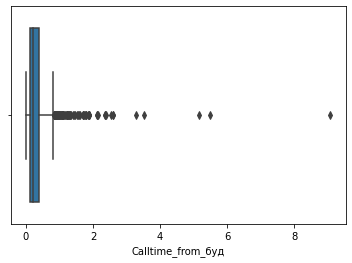

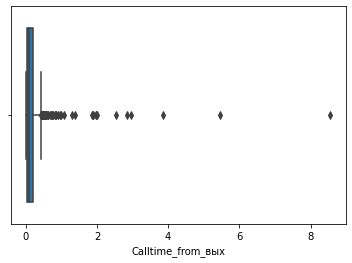

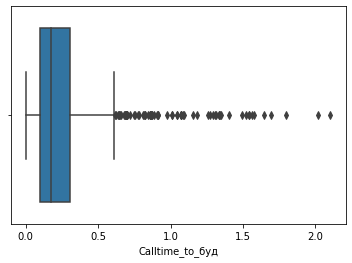

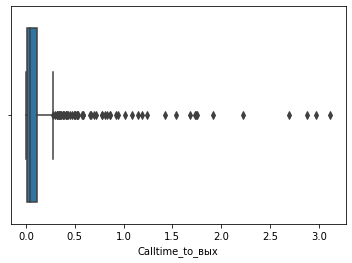

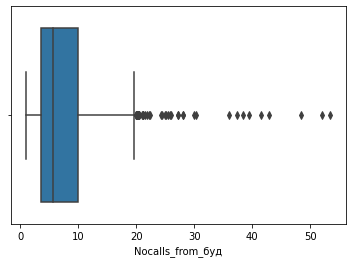

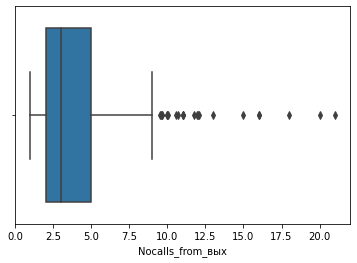

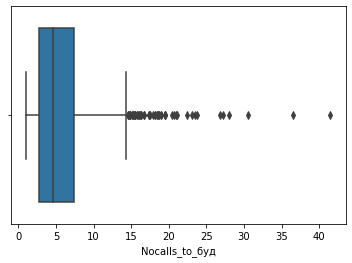

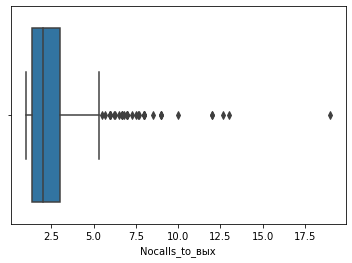

In [24]:
for col in calls.columns[1:]:
    sns.boxplot(data=calls, x=col)
    plt.show()

In [25]:
for col in calls.columns[1:]:
    bins = calls[col].quantile([0, 0.25, 0.5, 0.75, 1], )
    calls[col] = pd.cut(calls[col], bins, labels=[1, 2, 3, 4])
calls.head()

,id,Calltime_from_буд,Calltime_from_вых,Calltime_to_буд,Calltime_to_вых,Nocalls_from_буд,Nocalls_from_вых,Nocalls_to_буд,Nocalls_to_вых
0,ОРГ1-00004,4,3,4,4,4,4,4,4
1,ОРГ1-00005,4,4,4,4,4,3,3,2
2,ОРГ1-00028,2,1,2,3,2,NaN,3,2
3,ОРГ1-00030,2,NaN,2,2,3,NaN,3,NaN
4,ОРГ1-00044,3,4,4,3,3,1,4,3


In [26]:
df = df.merge(calls, on='id', how='outer')

#### Время за компьютером

In [27]:
wd = pd.read_csv('WorkingDay.csv')
wd.head()

,startTime,activeTime,Вых/Будни,monitorTime,id
0,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-01553
1,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-02112
2,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-02112
3,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-01846
4,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-01846


In [28]:
wd.isna().sum()

startTime      0
activeTime     0
Вых/Будни      0
monitorTime    0
id             0
dtype: int64

Сгруппируем данные по ид, виду дней недели, посчитаем средние и медианные значения времени активной работы и активности монитора.

In [29]:
wd_agg = wd.groupby(['id', 'Вых/Будни'], as_index=False) \
  .agg({'activeTime': ['mean', 'median'],
        'monitorTime': ['mean', 'median']})

wd_agg.columns = ['id', 'Вых/Будни', 'activeTime_mean', 'activeTime_median', 'monitorTime_mean', 'monitorTime_median']
wd_agg.head()

,id,Вых/Будни,activeTime_mean,activeTime_median,monitorTime_mean,monitorTime_median
0,ОРГ1-00004,Будни,1389.785864,610.5,4472.757592,1003.0
1,ОРГ1-00004,Выходные дни,738.520295,152.0,10105.081181,389.0
2,ОРГ1-00028,Будни,2754.448193,444.0,7673.428313,689.0
3,ОРГ1-00028,Выходные дни,412.803279,0.0,67756.786885,85784.0
4,ОРГ1-00030,Будни,1750.411583,299.0,2119.393457,328.5


In [30]:
wd_agg = wd_agg.pivot(index='id', columns=['Вых/Будни'], values=['activeTime_mean', 'activeTime_median', 'monitorTime_mean', 'monitorTime_median']) \
               .reset_index()
wd_agg.columns = ['id', 'activeTime_mean_буд', 'activeTime_mean_вых', 'activeTime_median_буд', 'activeTime_median_вых', 
                  'monitorTime_mean_буд', 'monitorTime_mean_вых', 'monitorTime_median_буд', 'monitorTime_median_вых']
wd_agg.head()

,id,activeTime_mean_буд,activeTime_mean_вых,activeTime_median_буд,activeTime_median_вых,monitorTime_mean_буд,monitorTime_mean_вых,monitorTime_median_буд,monitorTime_median_вых
0,ОРГ1-00004,1389.785864,738.520295,610.5,152.0,4472.757592,10105.081181,1003.0,389.0
1,ОРГ1-00028,2754.448193,412.803279,444.0,0.0,7673.428313,67756.786885,689.0,85784.0
2,ОРГ1-00030,1750.411583,341.000000,299.0,59.0,2119.393457,352.833333,328.5,64.5
3,ОРГ1-00044,1703.285628,641.049689,623.0,258.0,2473.628260,1967.826087,903.0,637.0
4,ОРГ1-00046,1193.287123,794.798507,283.5,133.0,2459.286543,2575.957090,337.0,186.0


In [31]:
for col in wd_agg.columns[1:]:
    bins = wd_agg[col].quantile([0, 0.25, 0.5, 0.75, 1])
    wd_agg[col] = pd.cut(wd_agg[col], bins, labels=[1, 2, 3, 4])
wd_agg.head()

,id,activeTime_mean_буд,activeTime_mean_вых,activeTime_median_буд,activeTime_median_вых,monitorTime_mean_буд,monitorTime_mean_вых,monitorTime_median_буд,monitorTime_median_вых
0,ОРГ1-00004,2,3,4,3,3,3,4,2
1,ОРГ1-00028,4,2,3,NaN,4,4,3,4
2,ОРГ1-00030,3,2,2,2,2,1,1,1
3,ОРГ1-00044,3,3,4,4,2,2,4,3
4,ОРГ1-00046,2,3,2,3,2,2,1,2


In [32]:
df = df.merge(wd_agg, on = 'id', how = 'outer')

#### Опоздания

In [33]:
late = pd.read_csv('ConnectionTime.csv')
late.head()

C:\Users\nasta\AppData\Local\Temp\ipykernel_16004\2911176514.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  late = pd.read_csv('ConnectionTime.csv')


,dateNum,maxLogOff,Нормативное время начала раб.дня,Фактич. время начала раб.дня,Время опоздания,Признак опоздания,Вых/Будни,id
0,"2021-12-15 00:00:00,000","2021-12-15 17:30:27,246","1899-12-30 08:30:00,000","1899-12-30 08:24:18,606",NaN,NaN,Будни,ОРГ1-02782
1,"2021-12-15 00:00:00,000","2021-12-15 16:30:13,330","1899-12-30 08:30:00,000","1899-12-30 01:05:20,513",NaN,NaN,Будни,ОРГ1-01407
2,"2021-12-15 00:00:00,000","2021-12-15 15:27:37,246","1899-12-30 08:30:00,000","1899-12-30 05:47:33,156",NaN,NaN,Будни,ОРГ1-01909
3,"2021-12-15 00:00:00,000","2021-12-15 20:35:14,833","1899-12-30 08:30:00,000","1899-12-30 08:28:43,956",NaN,NaN,Будни,ОРГ1-00254
4,"2021-12-15 00:00:00,000","2021-12-15 17:32:16,913","1899-12-30 08:30:00,000","1899-12-30 08:16:02,896",NaN,NaN,Будни,ОРГ1-02543


In [34]:
late.isna().sum()

dateNum                                  0
maxLogOff                                0
Нормативное время начала раб.дня         0
Фактич. время начала раб.дня             0
Время опоздания                     127561
Признак опоздания                   153142
Вых/Будни                                0
id                                       0
dtype: int64

In [35]:
late.dtypes

dateNum                             object
maxLogOff                           object
Нормативное время начала раб.дня    object
Фактич. время начала раб.дня        object
Время опоздания                     object
Признак опоздания                   object
Вых/Будни                           object
id                                  object
dtype: object

Скорректируем типы данных по колонкам с датой-временем и временем опоздания

In [36]:
late['Время опоздания'] = late['Время опоздания'].apply(lambda x: str(x).replace(',', '.'))
late['Время опоздания'] = late['Время опоздания'].astype('float')

late['Нормативное время начала раб.дня'] = pd.to_datetime(late['Нормативное время начала раб.дня'])
late['Фактич. время начала раб.дня'] = pd.to_datetime(late['Фактич. время начала раб.дня'])
late['maxLogOff'] = pd.to_datetime(late['maxLogOff'])
late['dateNum'] = pd.to_datetime(late['dateNum'])

In [37]:
# строки не уникальны по паре ид - дата (оставим только самые ранние данные для каждого ид и дня)
late.duplicated(['id', 'dateNum']).sum()

52360

In [38]:
late = late.sort_values(['id', 'dateNum', 'Фактич. время начала раб.дня']).drop_duplicates(['id', 'dateNum'], keep='first')

In [39]:
late['Признак опоздания'] = late['Признак опоздания'].apply(lambda x: 1 if x == 'Опоздание' else 0)
late['Время опоздания'] = late['Время опоздания'].fillna(0)
late.head()

,dateNum,maxLogOff,Нормативное время начала раб.дня,Фактич. время начала раб.дня,Время опоздания,Признак опоздания,Вых/Будни,id
171924,2021-06-21,2021-06-21 18:52:17.730,1899-12-30 08:30:00,1899-12-30 08:46:00.716,0.266866,1,Будни,ОРГ1-00004
148474,2021-06-22,2021-06-22 18:29:59.000,1899-12-30 08:30:00,1899-12-30 08:33:42.583,0.061829,0,Будни,ОРГ1-00004
149721,2021-06-23,2021-06-23 18:53:07.696,1899-12-30 08:30:00,1899-12-30 08:36:47.690,0.113247,0,Будни,ОРГ1-00004
84955,2021-06-24,2021-06-24 18:21:01.880,1899-12-30 08:30:00,1899-12-30 08:29:50.333,0.000000,0,Будни,ОРГ1-00004
93011,2021-06-25,2021-06-25 17:50:45.690,1899-12-30 08:30:00,1899-12-30 08:27:45.113,0.000000,0,Будни,ОРГ1-00004


In [40]:
late = late.groupby(['id', 'Вых/Будни'], as_index=False) \
            .agg({'Время опоздания': 'mean', 'Признак опоздания': 'mean'})
late.columns = ['id', 'Вых/Будни', 'latetime_mean', 'latecnt_mean']
late = late.pivot(index='id', columns='Вых/Будни', values=['latetime_mean', 'latecnt_mean']).reset_index()
late.columns = ['id', 'latetime_mean_буд', 'latetime_mean_вых', 'latecnt_mean_буд', 'latecnt_mean_вых']

C:\Users\nasta\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


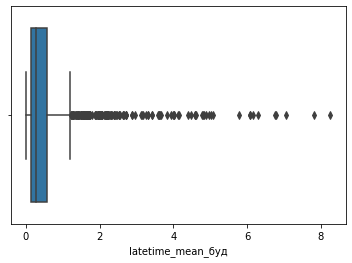

C:\Users\nasta\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


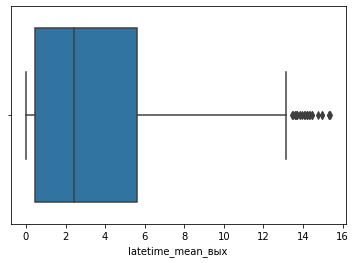

C:\Users\nasta\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


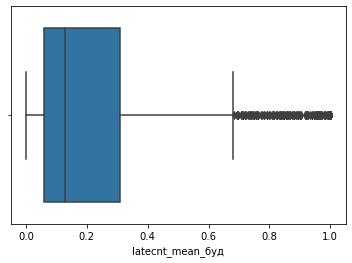

C:\Users\nasta\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


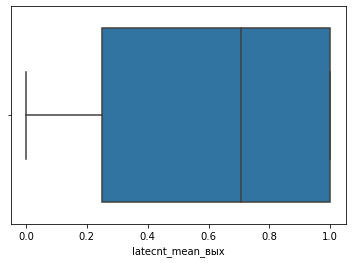

In [41]:
for col in late.columns[1:]:
    sns.boxplot(late[col])
    plt.show()

In [42]:
for col in late.columns[1:]:
    print(late[col].quantile([0, 0.25, 0.5, 0.75, 1]))

0.00    0.000000
0.25    0.128746
0.50    0.269262
0.75    0.558819
1.00    8.250858
Name: latetime_mean_буд, dtype: float64
0.00     0.000000
0.25     0.460647
0.50     2.447343
0.75     5.635471
1.00    15.374625
Name: latetime_mean_вых, dtype: float64
0.00    0.000000
0.25    0.058824
0.50    0.129032
0.75    0.307692
1.00    1.000000
Name: latecnt_mean_буд, dtype: float64
0.00    0.000000
0.25    0.250000
0.50    0.705882
0.75    1.000000
1.00    1.000000
Name: latecnt_mean_вых, dtype: float64


In [43]:
for col in late.columns[1:4]:
    bins = late[col].quantile([0, 0.25, 0.5, 0.75, 1])
    late[col] = pd.cut(late[col], bins, labels=[1, 2, 3, 4])
late['latecnt_mean_вых'] = pd.cut(late['latecnt_mean_вых'], 3, labels = [1, 2, 3])
late.head()

,id,latetime_mean_буд,latetime_mean_вых,latecnt_mean_буд,latecnt_mean_вых
0,ОРГ1-00004,4,4,4,3
1,ОРГ1-00028,1,4,1,3
2,ОРГ1-00030,3,3,2,1
3,ОРГ1-00044,2,3,2,3
4,ОРГ1-00046,4,3,4,3


In [44]:
df = df.merge(late, on='id', how='outer')

#### SKUD

In [45]:
skud = pd.read_csv('SKUD.csv')
skud.head()

,Дата,Приход.1,Уход.1,Длительность общая,Длительность раб.дня без обеда,Вых/Будни,id
0,"2021-03-01 00:00:00,000","1899-12-30 08:11:00,000","1899-12-30 17:32:00,000","9,35","8,35",Будни,ОРГ1-00791
1,"2021-03-01 00:00:00,000","1899-12-30 08:25:00,000","1899-12-30 17:32:00,000","9,1166666666666671","8,1166666666666671",Будни,ОРГ1-01826
2,"2021-03-01 00:00:00,000","1899-12-30 08:31:00,000","1899-12-30 17:32:00,000","9,0166666666666657","8,0166666666666657",Будни,ОРГ1-00713
3,"2021-03-01 00:00:00,000","1899-12-30 08:31:00,000","1899-12-30 17:32:00,000","9,0166666666666657","8,0166666666666657",Будни,ОРГ1-02127
4,"2021-03-01 00:00:00,000","1899-12-30 08:19:00,000","1899-12-30 17:32:00,000","9,2166666666666668","8,2166666666666668",Будни,ОРГ1-01739


In [46]:
skud.dtypes

Дата                              object
Приход.1                          object
Уход.1                            object
Длительность общая                object
Длительность раб.дня без обеда    object
Вых/Будни                         object
id                                object
dtype: object

In [47]:
skud.duplicated(['id', 'Дата']).sum()

792

In [48]:
skud = skud.sort_values(['id', 'Дата', 'Приход.1']).drop_duplicates(['id', 'Дата'], keep='first')
skud.head(3)

,Дата,Приход.1,Уход.1,Длительность общая,Длительность раб.дня без обеда,Вых/Будни,id
16242,"2021-03-01 00:00:00,000","1899-12-30 08:10:00,000","1899-12-30 19:16:00,000","11,1","10,1",Будни,ОРГ1-00002
17388,"2021-03-02 00:00:00,000","1899-12-30 08:15:00,000","1899-12-30 22:23:00,000","14,133333333333333","12,133333333333333",Будни,ОРГ1-00002
15973,"2021-03-03 00:00:00,000","1899-12-30 08:12:00,000","1899-12-30 19:07:00,000","10,916666666666666","9,9166666666666661",Будни,ОРГ1-00002


In [49]:
skud['Длительность общая'] = skud['Длительность общая'].apply(lambda x: x.replace(',', '.')).astype('float')
skud = skud.groupby(['id', 'Вых/Будни'], as_index=False) \
    .agg({'Длительность общая': 'mean'})
skud.head()

,id,Вых/Будни,Длительность общая
0,ОРГ1-00002,Будни,11.312500
1,ОРГ1-00004,Будни,9.353646
2,ОРГ1-00005,Будни,9.719444
3,ОРГ1-00005,Выходные дни,6.210000
4,ОРГ1-00008,Будни,5.428571


In [50]:
skud = skud.pivot(index='id', columns='Вых/Будни', values='Длительность общая').reset_index()
skud.columns = ['id', 'Длительность_дня_буд', 'Длительность_дня_вых']
skud.head(3)

,id,Длительность_дня_буд,Длительность_дня_вых
0,ОРГ1-00002,11.312500,NaN
1,ОРГ1-00004,9.353646,NaN
2,ОРГ1-00005,9.719444,6.21


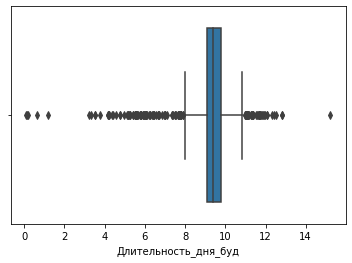

<AxesSubplot:xlabel='Длительность_дня_вых'>

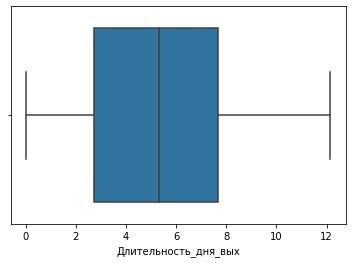

In [51]:
sns.boxplot(data=skud, x='Длительность_дня_буд')
plt.show()
sns.boxplot(data=skud, x='Длительность_дня_вых')

In [52]:
for col in skud.columns[1:]:
    bins = skud[col].quantile([0, 0.25, 0.5, 0.75, 1])
    skud[col] = pd.cut(skud[col], bins, labels=[1, 2, 3, 4])
skud.head()

,id,Длительность_дня_буд,Длительность_дня_вых
0,ОРГ1-00002,4,NaN
1,ОРГ1-00004,2,NaN
2,ОРГ1-00005,3,3
3,ОРГ1-00008,1,NaN
4,ОРГ1-00010,1,1


In [53]:
df = df.merge(skud, on='id', how='outer')

#### Задания

In [54]:
tasks = pd.read_csv('Tasks.csv')
tasks.head()

C:\Users\nasta\AppData\Local\Temp\ipykernel_16004\497200217.py:1: DtypeWarning: Columns (1,7) have mixed types. Specify dtype option on import or set low_memory=False.
  tasks = pd.read_csv('Tasks.csv')


,Статус по просрочке,Срок плановый,"Просрочено, дней",ДлительностьПросрочки,ID задачи,Вид документа,Дата старта задания,Дата завершения задания плановая,Дата завершения задания фактическая,Состояние задания,id
0,Без нарушения срока,NaN,0,без нарушения срока,E1DE844D-EE2D-4C41-AEDF-93F246749F0E,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
1,Без нарушения срока,NaN,0,без нарушения срока,7A92343C-8C9A-46E7-AC81-8F50F95009D0,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
2,Без нарушения срока,NaN,0,без нарушения срока,5CE64E52-D2D1-4DCC-B2C8-34734AA39AC0,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
3,Без нарушения срока,NaN,0,без нарушения срока,7A28F3DD-983F-4127-AB7F-6EDB85A69F1C,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
4,Без нарушения срока,NaN,0,без нарушения срока,ABFFAF61-12D8-44C2-B1F6-8402D174889E,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588


In [55]:
tasks.isna().sum()

Статус по просрочке                         0
Срок плановый                          520839
Просрочено, дней                            0
ДлительностьПросрочки                       0
ID задачи                                   0
Вид документа                            3517
Дата старта задания                         0
Дата завершения задания плановая       262603
Дата завершения задания фактическая     15977
Состояние задания                           0
id                                          0
dtype: int64

In [56]:
tasks['Статус по просрочке'].value_counts(dropna=False)

Без нарушения срока    454148
С нарушением срока      82512
Name: Статус по просрочке, dtype: int64

In [57]:
tasks['ДлительностьПросрочки'].value_counts(dropna=False)

без нарушения срока    454148
более 30 дней           34620
до 7 дней               31984
до 30 дней              15908
Name: ДлительностьПросрочки, dtype: int64

In [58]:
tasks['Состояние задания'].value_counts(dropna=False)

Завершено                  520779
Не начато                    7842
В работе                     7571
Делегировано                  344
На приёмке                     60
Отложено                       55
Возврат с делегирования         9
Name: Состояние задания, dtype: int64

In [59]:
# рассмотрим только завершенные задания
tasks = tasks[tasks['Состояние задания'] == 'Завершено']

In [60]:
tasks_by_user = tasks.groupby(['id'], as_index=False).agg({'ID задачи': 'count'}).rename(columns={'ID задачи': 'Всего_задач'})

In [61]:
tasks_late = tasks.groupby(['id', 'ДлительностьПросрочки'], as_index=False).agg({'ID задачи': 'count'}).rename(columns={'ID задачи': 'Задач'})

In [62]:
tasks = tasks_by_user.merge(tasks_late, on='id', how='left')
tasks['Доля_выполненных_задач'] = tasks['Задач'] / tasks['Всего_задач']

In [63]:
tasks = tasks.pivot(index='id', columns='ДлительностьПросрочки', values=['Доля_выполненных_задач']).reset_index()
tasks.columns = ['id', 'Доля_задач_без_нарушения', 'Доля_задач_просрок_30', 'Доля_задач_просрок_до_30', 'Доля_задач_просрок_до_7']
tasks.head()

,id,Доля_задач_без_нарушения,Доля_задач_просрок_30,Доля_задач_просрок_до_30,Доля_задач_просрок_до_7
0,ОРГ1-00004,0.915921,0.005367,0.017889,0.060823
1,ОРГ1-00005,0.974763,0.007661,0.005408,0.012168
2,ОРГ1-00028,0.962810,NaN,0.012397,0.024793
3,ОРГ1-00030,0.861111,NaN,0.027778,0.111111
4,ОРГ1-00044,0.713376,0.050955,0.073248,0.162420


In [64]:
for col in tasks.columns[1:]:
    bins = tasks[col].quantile([0, 0.25, 0.5, 0.75, 1])
    tasks[col] = pd.cut(tasks[col], bins=bins, labels=[1, 2, 3, 4])
tasks.head()

,id,Доля_задач_без_нарушения,Доля_задач_просрок_30,Доля_задач_просрок_до_30,Доля_задач_просрок_до_7
0,ОРГ1-00004,3,1,1,2
1,ОРГ1-00005,4,1,1,1
2,ОРГ1-00028,4,NaN,1,1
3,ОРГ1-00030,3,NaN,2,3
4,ОРГ1-00044,2,2,3,3


In [65]:
df = df.merge(tasks, on='id', how='outer')

#### Интервалы активности

In [66]:
timenet = pd.read_csv('TimenNetwork.csv')
timenet.head(3)

,Вых/Будни,monitor_Time,startTime,id
0,Будни,300,"2021-08-16 00:00:00,000",ОРГ1-01402
1,Будни,300,"2021-08-18 00:00:00,000",ОРГ1-01402
2,Будни,300,"2021-08-19 00:00:00,000",ОРГ1-01402


In [67]:
df = df.merge(train_df, on='id', how='outer')

In [68]:
df.isna().sum()

id                             0
Вид_образования              556
Специальность                556
Кол-во курсов                556
Повышение_квалификации       556
Calltime_from_буд           4337
Calltime_from_вых           4915
Calltime_to_буд             4412
Calltime_to_вых             4918
Nocalls_from_буд            4357
Nocalls_from_вых            4970
Nocalls_to_буд              4429
Nocalls_to_вых              5008
activeTime_mean_буд         3852
activeTime_mean_вых         4124
activeTime_median_буд       3852
activeTime_median_вых       4321
monitorTime_mean_буд        3852
monitorTime_mean_вых        4045
monitorTime_median_буд      3852
monitorTime_median_вых      4045
latetime_mean_буд           3768
latetime_mean_вых           4197
latecnt_mean_буд            3778
latecnt_mean_вых            4093
Длительность_дня_буд        4482
Длительность_дня_вых        5238
Доля_задач_без_нарушения    4157
Доля_задач_просрок_30       4643
Доля_задач_просрок_до_30    4505
Доля_задач

In [69]:
df['Вид_образования'] = df['Вид_образования'].astype('str')
df['Специальность'] = df['Специальность'].astype('str')

In [70]:
for col in ['Calltime_from_буд', 'Calltime_from_вых',
       'Calltime_to_буд', 'Calltime_to_вых', 'Nocalls_from_буд',
       'Nocalls_from_вых', 'Nocalls_to_буд', 'Nocalls_to_вых',
       'activeTime_mean_буд', 'activeTime_mean_вых', 'activeTime_median_буд',
       'activeTime_median_вых', 'monitorTime_mean_буд', 'monitorTime_mean_вых',
       'monitorTime_median_буд', 'monitorTime_median_вых', 'latetime_mean_буд',
       'latetime_mean_вых', 'latecnt_mean_буд', 'latecnt_mean_вых',
       'Длительность_дня_буд', 'Длительность_дня_вых',
       'Доля_задач_без_нарушения', 'Доля_задач_просрок_30',
       'Доля_задач_просрок_до_30', 'Доля_задач_просрок_до_7']:
    df[col] = df[col].astype('str')

In [71]:
df.shape

(5344, 32)

In [72]:
train_df = df[df['type'].notna()]

In [73]:
train_df.isna().sum()

id                           0
Вид_образования              0
Специальность                0
Кол-во курсов               71
Повышение_квалификации      71
Calltime_from_буд            0
Calltime_from_вых            0
Calltime_to_буд              0
Calltime_to_вых              0
Nocalls_from_буд             0
Nocalls_from_вых             0
Nocalls_to_буд               0
Nocalls_to_вых               0
activeTime_mean_буд          0
activeTime_mean_вых          0
activeTime_median_буд        0
activeTime_median_вых        0
monitorTime_mean_буд         0
monitorTime_mean_вых         0
monitorTime_median_буд       0
monitorTime_median_вых       0
latetime_mean_буд            0
latetime_mean_вых            0
latecnt_mean_буд             0
latecnt_mean_вых             0
Длительность_дня_буд         0
Длительность_дня_вых         0
Доля_задач_без_нарушения     0
Доля_задач_просрок_30        0
Доля_задач_просрок_до_30     0
Доля_задач_просрок_до_7      0
type                         0
dtype: i

# Посмотрим на распределение целевой переменной

Text(0.5, 1.0, 'Распределение предсказываемой величины')

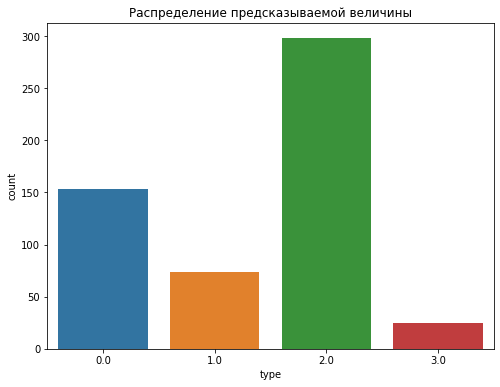

In [74]:
plt.figure(figsize=(8,6))
sns.countplot(x="type" , data=df).set_title('Распределение предсказываемой величины')

In [75]:
X = train_df.drop(columns='type')
y = train_df['type']

Как видим, распределение классов весьма неравномерно, это необходимо учесть для при обучении модели

In [76]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(train_df['type'])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))
class_weights

{0.0: 0.8986928104575164,
 1.0: 1.8581081081081081,
 2.0: 0.46140939597315433,
 3.0: 5.5}

## Подготовим датасет к обучению модели

In [78]:
X.head()

,id,Вид_образования,Специальность,Кол-во курсов,Повышение_квалификации,Calltime_from_буд,Calltime_from_вых,Calltime_to_буд,Calltime_to_вых,Nocalls_from_буд,...,latetime_mean_буд,latetime_mean_вых,latecnt_mean_буд,latecnt_mean_вых,Длительность_дня_буд,Длительность_дня_вых,Доля_задач_без_нарушения,Доля_задач_просрок_30,Доля_задач_просрок_до_30,Доля_задач_просрок_до_7
10,ОРГ1-00057,повышен высш образован бакалавриат квалификац,производств предприят прочност оборудован маши...,4.0,1.0,2,nan,2,nan,2,...,1,3,1,3,4,nan,3,1,nan,2
15,ОРГ1-00081,образован высш,производств процесс автоматизац технологическ ...,1.0,0.0,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
16,ОРГ1-00085,образован повышен высш квалификац,конструктивн решен оборудован старт нефтегазоп...,4.0,1.0,3,1,3,2,4,...,2,3,1,3,3,2,3,1,2,2
19,ОРГ1-00100,образован повышен высш квалификац,газов прочност оборудован нефтян промысл аппар...,2.0,1.0,1,nan,3,nan,1,...,2,nan,1,nan,4,4,4,nan,2,1
31,ОРГ1-00148,образован высш,,1.0,0.0,2,nan,2,nan,2,...,3,4,2,3,2,nan,2,2,2,3


## Выделим выборки

In [79]:
random_state = 42

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_state)

## Обучение модели

Для обучения модели в catboost выделим категориальные и текстовые признаки

In [80]:
X.columns

Index(['id', 'Вид_образования', 'Специальность', 'Кол-во курсов',
       'Повышение_квалификации', 'Calltime_from_буд', 'Calltime_from_вых',
       'Calltime_to_буд', 'Calltime_to_вых', 'Nocalls_from_буд',
       'Nocalls_from_вых', 'Nocalls_to_буд', 'Nocalls_to_вых',
       'activeTime_mean_буд', 'activeTime_mean_вых', 'activeTime_median_буд',
       'activeTime_median_вых', 'monitorTime_mean_буд', 'monitorTime_mean_вых',
       'monitorTime_median_буд', 'monitorTime_median_вых', 'latetime_mean_буд',
       'latetime_mean_вых', 'latecnt_mean_буд', 'latecnt_mean_вых',
       'Длительность_дня_буд', 'Длительность_дня_вых',
       'Доля_задач_без_нарушения', 'Доля_задач_просрок_30',
       'Доля_задач_просрок_до_30', 'Доля_задач_просрок_до_7'],
      dtype='object')

In [81]:
text_features = ['Вид_образования', 'Специальность']
cat_features = ['id', 'Calltime_from_буд', 'Calltime_from_вых',
       'Calltime_to_буд', 'Calltime_to_вых', 'Nocalls_from_буд',
       'Nocalls_from_вых', 'Nocalls_to_буд', 'Nocalls_to_вых',
       'activeTime_mean_буд', 'activeTime_mean_вых', 'activeTime_median_буд',
       'activeTime_median_вых', 'monitorTime_mean_буд', 'monitorTime_mean_вых',
       'monitorTime_median_буд', 'monitorTime_median_вых', 'latetime_mean_буд',
       'latetime_mean_вых', 'latecnt_mean_буд', 'latecnt_mean_вых',
       'Длительность_дня_буд', 'Длительность_дня_вых',
       'Доля_задач_без_нарушения', 'Доля_задач_просрок_30',
       'Доля_задач_просрок_до_30', 'Доля_задач_просрок_до_7']

model = CatBoostClassifier(learning_rate=0.1,
                           eval_metric='AUC',
                           random_state=random_state,
                           iterations=600,
                           loss_function='MultiClassOneVsAll', 
                           class_weights=class_weights,
                           bootstrap_type='Bernoulli',
                           cat_features=cat_features,
                           text_features=text_features,
                           tokenizers=[
                                        {
                                            'tokenizer_id': 'Sense',
                                            'separator_type': 'BySense',
                                            'lowercasing': 'True',
                                            'token_types':['Word', 'Number', 'SentenceBreak'],
                                            'sub_tokens_policy':'SeveralTokens'
                                        }      
                                    ],
                                    dictionaries = [
                                        {
                                            'dictionary_id': 'Word',
                                            'max_dictionary_size': '50000'
                                        }
                                    ],
                                    feature_calcers = [
                                        'BoW:top_tokens_count=10000'
                                    ]
                           ,
                           verbose=200)

In [82]:
print(model.get_params())

{'iterations': 600, 'learning_rate': 0.1, 'loss_function': 'MultiClassOneVsAll', 'verbose': 200, 'class_weights': {0.0: 0.8986928104575164, 1.0: 1.8581081081081081, 2.0: 0.46140939597315433, 3.0: 5.5}, 'eval_metric': 'AUC', 'bootstrap_type': 'Bernoulli', 'random_state': 42, 'cat_features': ['id', 'Calltime_from_буд', 'Calltime_from_вых', 'Calltime_to_буд', 'Calltime_to_вых', 'Nocalls_from_буд', 'Nocalls_from_вых', 'Nocalls_to_буд', 'Nocalls_to_вых', 'activeTime_mean_буд', 'activeTime_mean_вых', 'activeTime_median_буд', 'activeTime_median_вых', 'monitorTime_mean_буд', 'monitorTime_mean_вых', 'monitorTime_median_буд', 'monitorTime_median_вых', 'latetime_mean_буд', 'latetime_mean_вых', 'latecnt_mean_буд', 'latecnt_mean_вых', 'Длительность_дня_буд', 'Длительность_дня_вых', 'Доля_задач_без_нарушения', 'Доля_задач_просрок_30', 'Доля_задач_просрок_до_30', 'Доля_задач_просрок_до_7'], 'text_features': ['Вид_образования', 'Специальность'], 'tokenizers': [{'tokenizer_id': 'Sense', 'separator_type

In [84]:
model.fit(X_train, y_train,
          eval_set=(X_val, y_val))

0:	test: 0.5000000	best: 0.5000000 (0)	total: 15.3ms	remaining: 9.15s
200:	test: 0.7574006	best: 0.7791321 (140)	total: 24.8s	remaining: 49.2s
400:	test: 0.7398003	best: 0.7791321 (140)	total: 49.9s	remaining: 24.7s
599:	test: 0.7325324	best: 0.7791321 (140)	total: 1m 15s	remaining: 0us

bestTest = 0.7791321052
bestIteration = 140

Shrink model to first 141 iterations.


In [85]:
fi = model.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,Calltime_from_буд,9.978680
1,Доля_задач_без_нарушения,6.050654
2,latecnt_mean_вых,5.787774
3,Nocalls_to_буд,5.467504
4,monitorTime_mean_вых,5.066143
5,Длительность_дня_буд,4.831471
6,activeTime_median_буд,4.818147
7,Nocalls_from_буд,4.581468
8,monitorTime_median_вых,4.118731
9,latetime_mean_вых,3.753078


## Оценка точности

In [86]:
test_pred = model.predict(X_val)
recall_score(y_val, test_pred, average='macro', zero_division = 0)

0.47468171296296297

# Cоздание файла с ответом

In [87]:
df_test = pd.read_csv("test_dataset_test.csv")
df_test.head()

,id,type
0,ОРГ1-02649,0
1,ОРГ2-05929,0
2,ОРГ2-05859,0
3,ОРГ1-00279,0
4,ОРГ2-01613,0


In [88]:
test = df.merge(df_test[['id']], on='id', how='right')

In [89]:
test_pred = model.predict(test.drop(columns='type'))

In [90]:
df_test["type"] = test_pred
df_test.head(4)

,id,type
0,ОРГ1-02649,2.0
1,ОРГ2-05929,1.0
2,ОРГ2-05859,1.0
3,ОРГ1-00279,0.0


In [91]:
df_test.to_csv("submission.csv", index=False)